# Notebook 13 d) Multi-class Sentiment Model Using Neural Networks

This notebook seeks to train a MULTI-CLASS model to predict sentiment on the full dataset based only on the noun phrases previously extracted but using neural network models instead of machine learning.

* Section 1 - Import libraries and data
* Section 2 - Data preprocessing
* Section 3 - Building a sentiment model (Models 1 to 5 based on the best simple networks from Notebook 8)
* Section 4 - Summary results table

NOTE: Cross validation could not be run on this dataset as it is too resource-intensive. Only a hold-out set is used for evaluation.

Datasets need to run file:
* combined_sentiment.csv
* combined_sentiment_test.csv

Models saved to:
* SentimentModels1
* SentimentModels2
* SentimentModels3
* SentimentModels4
* SentimentModels5

Final results:

* results_sentiment.csv


# Section 1: Import libraries and data

In [192]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,SpatialDropout1D,Conv1D,GlobalMaxPooling1D,SimpleRNN,LSTM,GRU,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE

import os
import pickle

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

In [193]:
# Bring in training and test sets from Notebook 11 (visualising topic models)
df_train = pd.read_csv("combined_sentiment.csv",index_col = 0)
df_test = pd.read_csv("combined_sentiment_test.csv",index_col = 0)

In [194]:
# Combine train and test set
df_combined_all = pd.concat([df_train, df_test],axis = 0,ignore_index = True)
df_combined_all.shape

(73027, 15)

# Section 2: Data preprocessing

In [195]:
# Choose columns, replace incorrect category label and relabel columns
df_train = df_train[["OrigInd","Category","noun_phrases","Topic Count","Sentiment","Score"]]
df_train.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]
df_test = df_test[["OrigInd","Category","noun_phrases","Topic","Sentiment","Score"]]
df_test["Category"].replace({"Attract": "Attractions"}, inplace=True)
df_test.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]

In [196]:
# Get Category distribution
df_combined_all["Category"].value_counts()

Food             40587
Accommodation    24670
Attractions       7560
Attract            210
Name: Category, dtype: int64

In [197]:
df_combined_all.head(2)

,Unnamed: 0.1,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF,Sentiment,Score,Sentence,Topic
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation,"['shame', 'accommodation']",VFM,VisitExp,-0.4767,negative,NaN,NaN
1,1,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,night stay december post-christmas,"['night', 'post-christmas']",Hotel Location,Restaurant,0.0000,neutral,NaN,NaN


In [198]:
# Get Polarity distribution
df_combined_all["Score"].value_counts()

neutral     39099
positive    29513
negative     4415
Name: Score, dtype: int64

<BarContainer object of 3 artists>

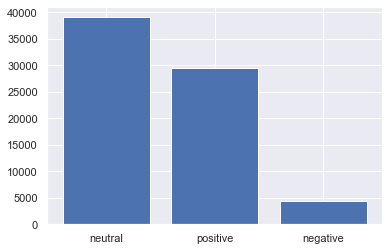

In [199]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])

In [200]:
df_combined_all["Score"].replace({"positive": 1,"negative":-1,"neutral":0}, inplace=True)
df_combined_all["Score"].value_counts()

 0    39099
 1    29513
-1     4415
Name: Score, dtype: int64

In [201]:
pos_sampled = df_combined_all[df_combined_all["Score"] == 1].sample(4415)
neutral_sampled = df_combined_all[df_combined_all["Score"] == 0].sample(4415)
negative = df_combined_all[df_combined_all["Score"] == -1]
print(pos_sampled.shape, neutral_sampled.shape,negative.shape)

(4415, 15) (4415, 15) (4415, 15)


In [202]:
df_combined_all = pd.concat([pos_sampled, neutral_sampled,negative], axis = 0, ignore_index = True)
df_combined_all.shape

(13245, 15)

<BarContainer object of 3 artists>

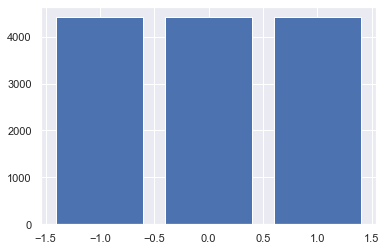

In [203]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])

## Define X and y and split into training, valuation and test sets

In [204]:
X = df_combined_all["noun_phrases"]
y = df_combined_all["Score"]

In [205]:
# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, random_state=42) 

In [206]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

(10596,) (1325,) (1324,) (10596,) (1325,) (1324,)


In [207]:
y_train.value_counts()

 0    3532
 1    3532
-1    3532
Name: Score, dtype: int64

In [208]:
y_val.value_counts()

 1    442
 0    442
-1    441
Name: Score, dtype: int64

In [209]:
y_test.value_counts()

-1    442
 1    441
 0    441
Name: Score, dtype: int64

## Distribution of noun phrases

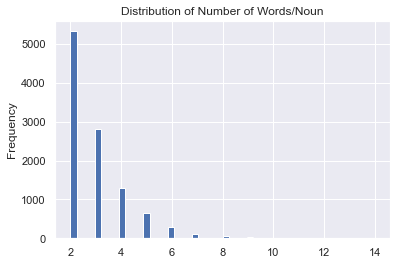

In [210]:
pd.DataFrame(X_train)["noun_phrases"].str.split().apply(len).plot.hist(bins = 50, title = "Distribution of Number of Words/Noun")
plt.show()

In [211]:
pd.DataFrame(X_train)["noun_phrases"].str.split().apply(len).max()

14

## Encoding X values

In [245]:
def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 20, padding = "post", truncating = "post", value = 0.0)
    
    return tokenizer, X_train_w, X_val_w, X_test_w

In [213]:
# Apply function to X training, validation and test sets
tok,X_train_w, X_val_w, X_test_w = tok(X_train, X_val, X_test)

In [214]:
# Save tokenizer objects for use in the combined final model
def tok_save(name,tokenizer):
    with open(name, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Save tokenizer pickle files
tok_save('tok_sent_multiclass.pickle',tok)

In [215]:
# Encode as one hot encoding for network
def bin(y_train, y_val, y_test):
    binarizer = preprocessing.LabelBinarizer()
    y_train_e = binarizer.fit_transform(y_train)
    y_val_e = binarizer.transform(y_val)
    y_test_e = binarizer.transform(y_test)
    return y_train_e,y_val_e,y_test_e

In [216]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)
def lab(y_train, y_val, y_test):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.fit_transform(y_val)
    y_test_l = le.transform(y_test)
    return y_train_l,y_val_l, y_test_l

In [217]:
y_train_e, y_val_e, y_test_e = bin(y_train, y_val, y_test)
y_train_l, y_val_l, y_test_l = lab(y_train, y_val, y_test)

In [218]:
print(y_train_e.shape, y_val_e.shape, y_test_e.shape)
print(y_train_l.shape, y_val_l.shape, y_test_l.shape)

(10596, 3) (1325, 3) (1324, 3)
(10596,) (1325,) (1324,)


In [219]:
pd.DataFrame(y_val).value_counts()

Score
 0       442
 1       442
-1       441
dtype: int64

# Section 3: Building a Sentiment Model

## Setting Functions

In [220]:
# Visualise the training and test accuracies and losses

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

In [221]:
# The model will use earlystopping if the valuation loss doesn't decrease after a specified number of epochs

def out(name):
    output_dir = name
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir
        
def call(output_dir,patience):
    modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
    callbacks = [EarlyStopping(monitor = "val_loss", patience = patience),modelcheckpoint]
    return callbacks

In [222]:
# Confusion Matrix function

def class_conf(y_val_integer,y_pred_class,labels):
    classification = classification_report(y_val_integer, y_pred_class)
    cf_matrix = confusion_matrix(y_val_integer, y_pred_class)
    fig, ax = plt.subplots(figsize = (8,6))
    sns.heatmap(cf_matrix, annot = True, fmt = "d",cmap = plt.cm.Blues,xticklabels = labels,yticklabels = labels)
    ax.set_xlabel('Predicted',labelpad = 10)
    ax.set_ylabel('Actual',labelpad = 10)
    plt.title("Confusion Matrix", fontsize = 15)
    print(classification)
    plt.show()

In [223]:
# Evaluation function

def eval(model,output_dir,name,X_val,y_val_e,y_val,labels):
    model.load_weights(output_dir+name)
    y_pred_prob = model.predict(X_val)
    y_pred_class = np.argmax(model.predict(X_val), axis=-1)
    y_val_integer = np.argmax(y_val, axis=1)
    df_pred = pd.DataFrame(list(zip(y_val_integer, y_val,y_pred_class)), columns=["Actual Class", "Actual Aspect","Predicted Class",])
    df_wrong = df_pred[df_pred["Actual Class"]!= df_pred["Predicted Class"]]
    class_conf(y_val_integer,y_pred_class,labels)
    print("\n")
    print("The model predicted:", df_wrong.shape[0],"aspects wrong from a total of:",df_pred.shape[0],"predictions")
    print("\n")
    return df_pred, df_wrong

In [224]:
# Metrics function

def metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob):
    accuracy = accuracy_score(y_val_integer, y_pred_class)
    rocauc = roc_auc_score(y_val_e,y_pred_prob, average = 'macro', multi_class = 'ovr')
    precision = precision_score(y_val_integer, y_pred_class, average='macro')
    recall = recall_score(y_val_integer, y_pred_class, average='macro')
    f1 = f1_score(y_val_integer, y_pred_class, average='macro')
          
    
    results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
    return results

In [225]:
# Balanced classes - get weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights

array([1., 1., 1.])

## Sentiment Model 1

In [226]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 8
epochs = 50
class_weights = {0:0.62257958,1:0.82480587,2:5.51349566}

# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass1')
callbacks = call(output_dir,5)

In [227]:
model1 = Sequential()
model1.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model1.add(Flatten())
model1.add(Dense(3, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model1.summary()) 
 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_8 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 963       
Total params: 96,963
Trainable params: 96,963
Non-trainable params: 0
_________________________________________________________________
None


In [228]:
# Model using keras embeddings
history = model1.fit(X_train_w,y_train_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val_e),
                    batch_size=batch_size)

Epoch 1/50
1325/1325 - 1s - loss: 0.7067 - accuracy: 0.7492 - val_loss: 0.3807 - val_accuracy: 0.8853
Epoch 2/50
1325/1325 - 1s - loss: 0.2430 - accuracy: 0.9315 - val_loss: 0.2422 - val_accuracy: 0.9223
Epoch 3/50
1325/1325 - 1s - loss: 0.1104 - accuracy: 0.9740 - val_loss: 0.2138 - val_accuracy: 0.9306
Epoch 4/50
1325/1325 - 1s - loss: 0.0568 - accuracy: 0.9895 - val_loss: 0.1989 - val_accuracy: 0.9396
Epoch 5/50
1325/1325 - 1s - loss: 0.0312 - accuracy: 0.9956 - val_loss: 0.1946 - val_accuracy: 0.9434
Epoch 6/50
1325/1325 - 1s - loss: 0.0177 - accuracy: 0.9984 - val_loss: 0.2049 - val_accuracy: 0.9434
Epoch 7/50
1325/1325 - 1s - loss: 0.0104 - accuracy: 0.9994 - val_loss: 0.2035 - val_accuracy: 0.9442
Epoch 8/50
1325/1325 - 1s - loss: 0.0065 - accuracy: 0.9996 - val_loss: 0.2100 - val_accuracy: 0.9442
Epoch 9/50
1325/1325 - 1s - loss: 0.0042 - accuracy: 0.9997 - val_loss: 0.2161 - val_accuracy: 0.9472
Epoch 10/50
1325/1325 - 1s - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.2187 - 

In [229]:
# Print training and test accuracies
loss, accuracy = model1.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_val_w, y_val_e, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9999
Validation Accuracy:  0.9449


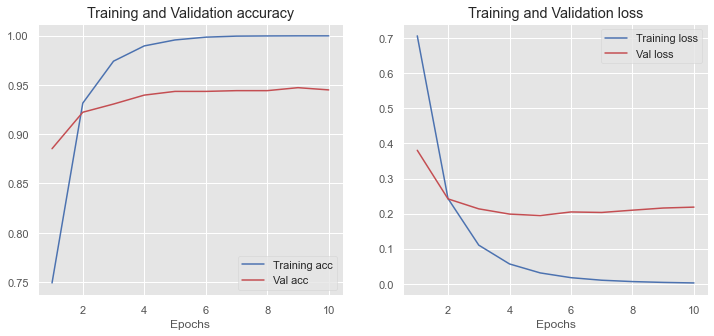

In [230]:
plot_history(history)

In [234]:
# Load model weights from epoch with best validation accuracy
model1.load_weights(output_dir+"/weights.09.hdf5")

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       441
           1       0.90      0.98      0.93       442
           2       0.97      0.93      0.95       442

    accuracy                           0.95      1325
   macro avg       0.95      0.95      0.95      1325
weighted avg       0.95      0.95      0.95      1325



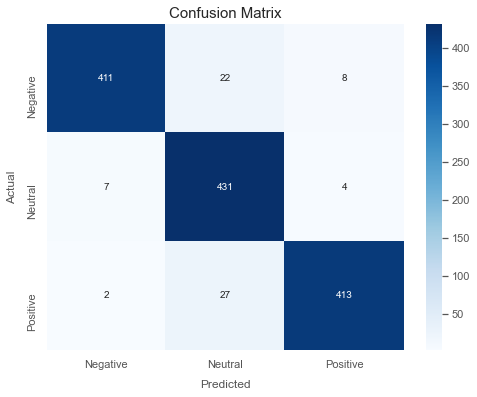

In [237]:
labels = ['Negative','Neutral','Positive']
y_pred_prob = model1.predict(X_val_w)
y_pred_class = np.argmax(model1.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [236]:
results1 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.94717,0.949418,0.947158,0.947446,0.987733


## Sentiment Model 2

In [42]:
model2 = Sequential()
model2.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model2.add(Flatten())
model2.add(Dense(64, activation='relu', input_shape=(1600,)))
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20544     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 116,739
Trainable params: 116,739
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
model2.save('bestsentimentnetworkmodel.h5')

In [44]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass2')
callbacks = call(output_dir,5)

In [45]:
# Model using keras embeddings
history = model2.fit(X_train_w,y_train_e,
                     epochs=epochs,
                     verbose=2,
                     callbacks = callbacks,
                     validation_data=(X_val_w, y_val_e),
                     batch_size=batch_size)
                

Epoch 1/50
1325/1325 - 1s - loss: 0.5164 - accuracy: 0.7848 - val_loss: 0.2322 - val_accuracy: 0.9260
Epoch 2/50
1325/1325 - 1s - loss: 0.1156 - accuracy: 0.9641 - val_loss: 0.1774 - val_accuracy: 0.9449
Epoch 3/50
1325/1325 - 1s - loss: 0.0292 - accuracy: 0.9931 - val_loss: 0.1759 - val_accuracy: 0.9532
Epoch 4/50
1325/1325 - 1s - loss: 0.0093 - accuracy: 0.9984 - val_loss: 0.1865 - val_accuracy: 0.9532
Epoch 5/50
1325/1325 - 1s - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.1947 - val_accuracy: 0.9517
Epoch 6/50
1325/1325 - 1s - loss: 7.2513e-04 - accuracy: 1.0000 - val_loss: 0.2283 - val_accuracy: 0.9540
Epoch 7/50
1325/1325 - 1s - loss: 2.4934e-04 - accuracy: 1.0000 - val_loss: 0.2280 - val_accuracy: 0.9555
Epoch 8/50
1325/1325 - 1s - loss: 1.0186e-04 - accuracy: 1.0000 - val_loss: 0.2496 - val_accuracy: 0.9577


In [46]:
# Print training and test accuracies
loss, accuracy = model2.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_val_w, y_val_e, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9577


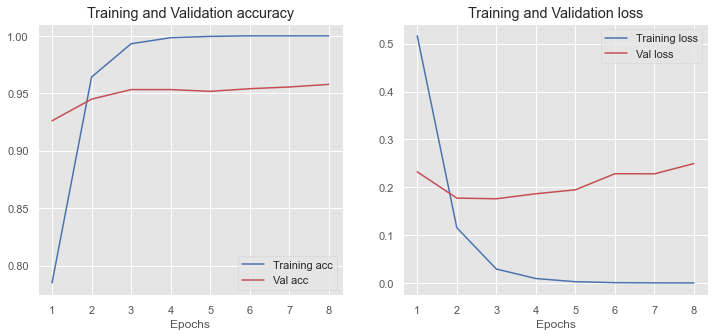

In [47]:
plot_history(history)

In [48]:
# Load model weights from epoch with best validation accuracy
model2.load_weights(output_dir+"/weights.08.hdf5")

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       441
           1       0.93      0.96      0.95       442
           2       0.96      0.97      0.96       442

    accuracy                           0.96      1325
   macro avg       0.96      0.96      0.96      1325
weighted avg       0.96      0.96      0.96      1325



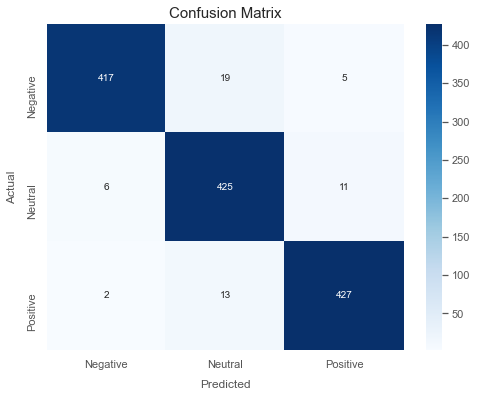

In [49]:
y_pred_prob = model2.predict(X_val_w)
y_pred_class = np.argmax(model2.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [50]:
results2 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.957736,0.958346,0.957727,0.957838,0.991276


## Sentiment Model 3

In [51]:
# Network with a hidden layer with more neurons in the dense layer and with dropout of 50%
model3 = Sequential()
model3.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(rate=0.5))
model3.add(Dense(3, activation='softmax')) 
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model3.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 137,475
Trainable params: 137,475
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass3')
callbacks = call(output_dir,5)

In [53]:
# Model using keras embeddings
history = model3.fit(X_train_w,y_train_e,
                     epochs=epochs,
                     verbose=2,
                     callbacks = callbacks,
                     validation_data=(X_val_w, y_val_e),
                     batch_size=batch_size)

Epoch 1/50
1325/1325 - 1s - loss: 0.5258 - accuracy: 0.7810 - val_loss: 0.2213 - val_accuracy: 0.9298
Epoch 2/50
1325/1325 - 1s - loss: 0.1345 - accuracy: 0.9588 - val_loss: 0.1561 - val_accuracy: 0.9517
Epoch 3/50
1325/1325 - 1s - loss: 0.0391 - accuracy: 0.9905 - val_loss: 0.1669 - val_accuracy: 0.9555
Epoch 4/50
1325/1325 - 1s - loss: 0.0141 - accuracy: 0.9969 - val_loss: 0.1739 - val_accuracy: 0.9570
Epoch 5/50
1325/1325 - 1s - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.1957 - val_accuracy: 0.9555
Epoch 6/50
1325/1325 - 1s - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.2261 - val_accuracy: 0.9502
Epoch 7/50
1325/1325 - 1s - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.2290 - val_accuracy: 0.9615


In [54]:
# Print training and test accuracies
loss, accuracy = model2.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_val_w, y_val_e, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9577


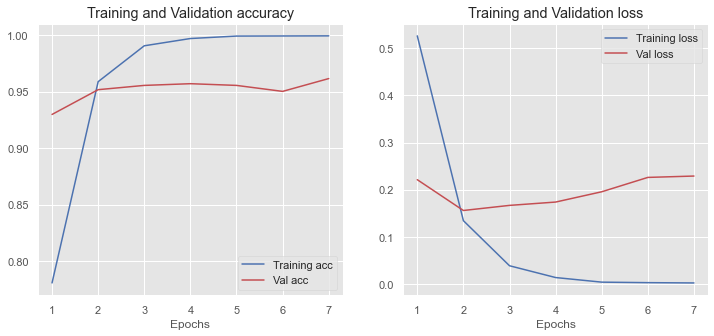

In [55]:
plot_history(history)

In [56]:
# Load model weights from epoch with best validation accuracy
model3.load_weights(output_dir+"/weights.07.hdf5")

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       441
           1       0.93      0.97      0.95       442
           2       0.98      0.96      0.97       442

    accuracy                           0.96      1325
   macro avg       0.96      0.96      0.96      1325
weighted avg       0.96      0.96      0.96      1325



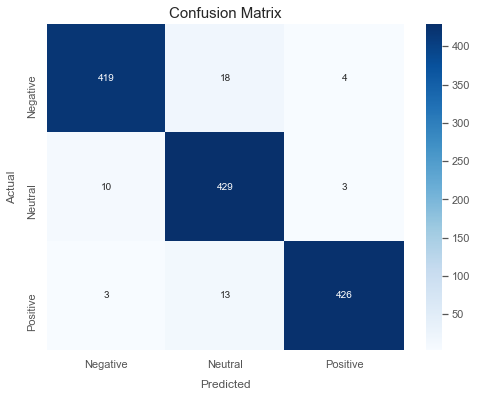

In [57]:
y_pred_prob = model3.predict(X_val_w)
y_pred_class = np.argmax(model3.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [58]:
results3 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.961509,0.962117,0.961501,0.961614,0.992114


## Sentiment Model 4

In [59]:
# Dense model with 2 hidden dense layers and dropout on each
model4 = Sequential()
model4.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(rate=0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(rate = 0.5))
model4.add(Dense(3, activation='softmax')) 
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [60]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass4')
callbacks = call(output_dir,5)

In [61]:
# Model using keras embeddings
history = model4.fit(X_train_w,y_train_e,
                     epochs=epochs,
                     verbose=2,
                     callbacks = callbacks,
                     validation_data=(X_val_w, y_val_e),
                     batch_size=batch_size)

Epoch 1/50
1325/1325 - 1s - loss: 0.5361 - accuracy: 0.7628 - val_loss: 0.2180 - val_accuracy: 0.9260
Epoch 2/50
1325/1325 - 1s - loss: 0.1249 - accuracy: 0.9639 - val_loss: 0.1648 - val_accuracy: 0.9509
Epoch 3/50
1325/1325 - 1s - loss: 0.0387 - accuracy: 0.9903 - val_loss: 0.1963 - val_accuracy: 0.9525
Epoch 4/50
1325/1325 - 1s - loss: 0.0179 - accuracy: 0.9964 - val_loss: 0.2178 - val_accuracy: 0.9547
Epoch 5/50
1325/1325 - 1s - loss: 0.0091 - accuracy: 0.9978 - val_loss: 0.2853 - val_accuracy: 0.9374
Epoch 6/50
1325/1325 - 1s - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.3203 - val_accuracy: 0.9230
Epoch 7/50
1325/1325 - 1s - loss: 0.0069 - accuracy: 0.9988 - val_loss: 0.3183 - val_accuracy: 0.9555


In [62]:
# Print training and test accuracies
loss, accuracy = model2.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_val_w, y_val_e, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9577


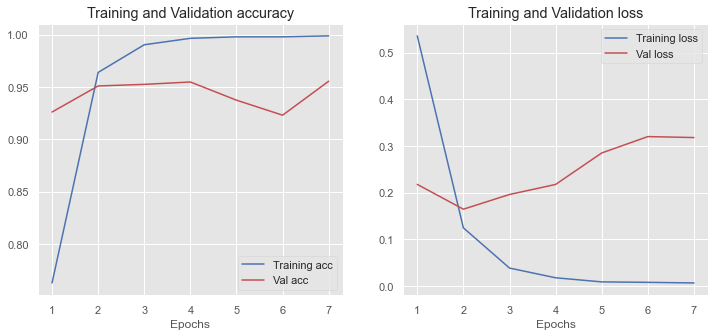

In [63]:
plot_history(history)

In [64]:
# Load model weights from epoch with best validation accuracy
model4.load_weights(output_dir+"/weights.07.hdf5")

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       441
           1       0.93      0.97      0.95       442
           2       0.97      0.97      0.97       442

    accuracy                           0.96      1325
   macro avg       0.96      0.96      0.96      1325
weighted avg       0.96      0.96      0.96      1325



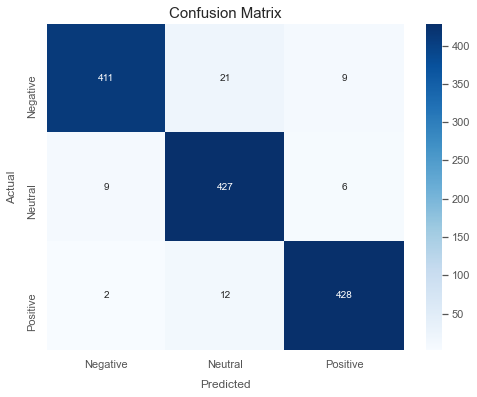

In [65]:
y_pred_prob = model4.predict(X_val_w)
y_pred_class = np.argmax(model4.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [66]:
results4 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results4

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.955472,0.956111,0.955454,0.955503,0.991142


##  Sentiment Model 5

In [82]:
# Dense model with 2 hidden dense layers and dropout on each
model5 = Sequential()
model5.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(rate=0.5))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(rate = 0.5))
model5.add(Dense(128,activation = 'relu'))
model5.add(Dense(3, activation='softmax')) 
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               164352    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

In [83]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass5')
callbacks = call(output_dir,5)

In [84]:
# Model using keras embeddings
history = model5.fit(X_train_w,y_train_e,
                     epochs=epochs,
                     verbose=2,
                     callbacks = callbacks,
                     validation_data=(X_val_w, y_val_e),
                     batch_size=batch_size)

Epoch 1/50
1325/1325 - 3s - loss: 0.4956 - accuracy: 0.7855 - val_loss: 0.1941 - val_accuracy: 0.9404
Epoch 2/50
1325/1325 - 2s - loss: 0.1264 - accuracy: 0.9646 - val_loss: 0.1605 - val_accuracy: 0.9509
Epoch 3/50
1325/1325 - 2s - loss: 0.0372 - accuracy: 0.9906 - val_loss: 0.1689 - val_accuracy: 0.9600
Epoch 4/50
1325/1325 - 2s - loss: 0.0190 - accuracy: 0.9948 - val_loss: 0.1952 - val_accuracy: 0.9698
Epoch 5/50
1325/1325 - 2s - loss: 0.0135 - accuracy: 0.9964 - val_loss: 0.2228 - val_accuracy: 0.9653
Epoch 6/50
1325/1325 - 2s - loss: 0.0132 - accuracy: 0.9967 - val_loss: 0.2380 - val_accuracy: 0.9623
Epoch 7/50
1325/1325 - 2s - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.2329 - val_accuracy: 0.9623


In [85]:
# Print training and test accuracies
loss, accuracy = model5.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model5.evaluate(X_val_w, y_val_e, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9992
Testing Accuracy:  0.9623


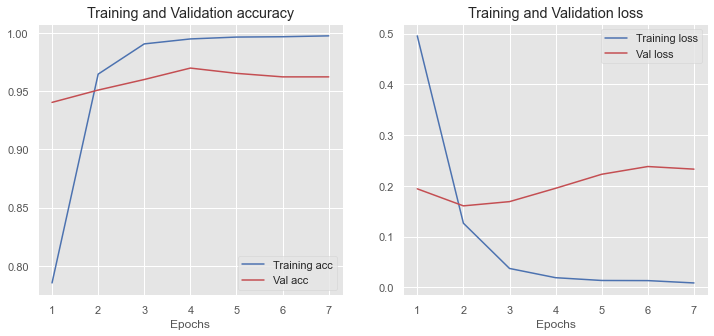

In [86]:
plot_history(history)

In [90]:
# Load model weights from epoch with best validation accuracy
model5.load_weights(output_dir+"/weights.04.hdf5")

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       441
           1       0.96      0.96      0.96       442
           2       0.99      0.97      0.98       442

    accuracy                           0.97      1325
   macro avg       0.97      0.97      0.97      1325
weighted avg       0.97      0.97      0.97      1325



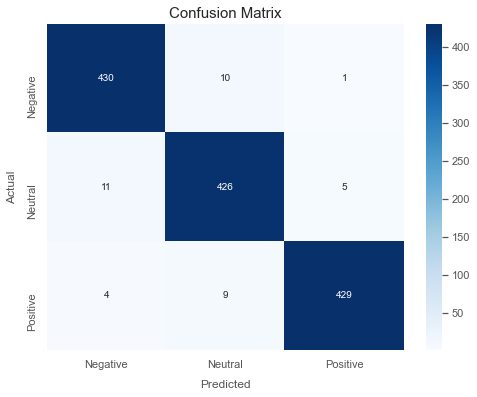

In [91]:
y_pred_prob = model5.predict(X_val_w)
y_pred_class = np.argmax(model5.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [92]:
results5 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results5

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.969811,0.969934,0.969815,0.969844,0.993286


In [250]:
model5.save("SentimentMultiNeural.h5")

# Section 4: Summary of results

In [75]:
models = ["Model1","Model2","Model3","Model4","Model5"]
summary_table = pd.concat([results1,results2,results3,results4,results5])
summary_table.set_index([models],inplace = True)
summary_table.to_csv("results_sentiment.csv")
summary_table.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Model5,0.964528,0.964622,0.964524,0.964548,0.992700
Model3,0.961509,0.962117,0.961501,0.961614,0.992114
Model2,0.957736,0.958346,0.957727,0.957838,0.991276
Model4,0.955472,0.956111,0.955454,0.955503,0.991142
Model1,0.956226,0.957014,0.956222,0.956355,0.991050
